## KNN and Cross Validation

In [1]:
library(ISLR2)
library(tidyverse)
library(ggplot2)
library(class)
library(reshape2)
library(Rfast)
library(MASS)

── Attaching packages ───────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: Rcpp

Loading required package: RcppZiggurat


Attaching package: ‘Rfast’


The following objects are masked from ‘package:class’:

    knn, knn.cv


The following object is masked from ‘package:dplyr’:

    nth


The following objects are masked from ‘package:purrr’:

    is_integer, transpose



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


The following object is masked fro

### 1. Training Error and Test Error

In [2]:
# split the traing and test data
test.perc = 0.2
set.seed(503)
train.index = sample(1:nrow(College), size = ceiling(nrow(College)*(1-test.perc)),replace = FALSE)
train.data = College[train.index, ]
test.data = College[-train.index, ]

# separate the label and X
train.label = train.data[, "Private"]
train.X = train.data[, -1]
test.label = test.data[, "Private"]
test.X = test.data[, -1]

# scale the data
mean_train = colMeans(train.X)
std_train = sqrt(diag(var(train.X)))
# training data
train.X = scale(train.X, center = mean_train, scale = std_train)
# test data
test.X = scale(test.X, center = mean_train, scale = std_train)

In [3]:
k_range = c(1:200)
train_error = c()
test_error = c()

for (k in k_range){
    
    pred_train = class::knn(train.X, train.X, train.label, k)
    train_error = c(train_error, mean(pred_train != train.label))
    
    pred_test = class::knn(train.X, test.X, train.label, k)
    test_error = c(test_error, mean(pred_test != test.label))    
}

errors = data.frame(k_range, train_error, test_error)
errors = melt(errors, id.vars = 'k_range')

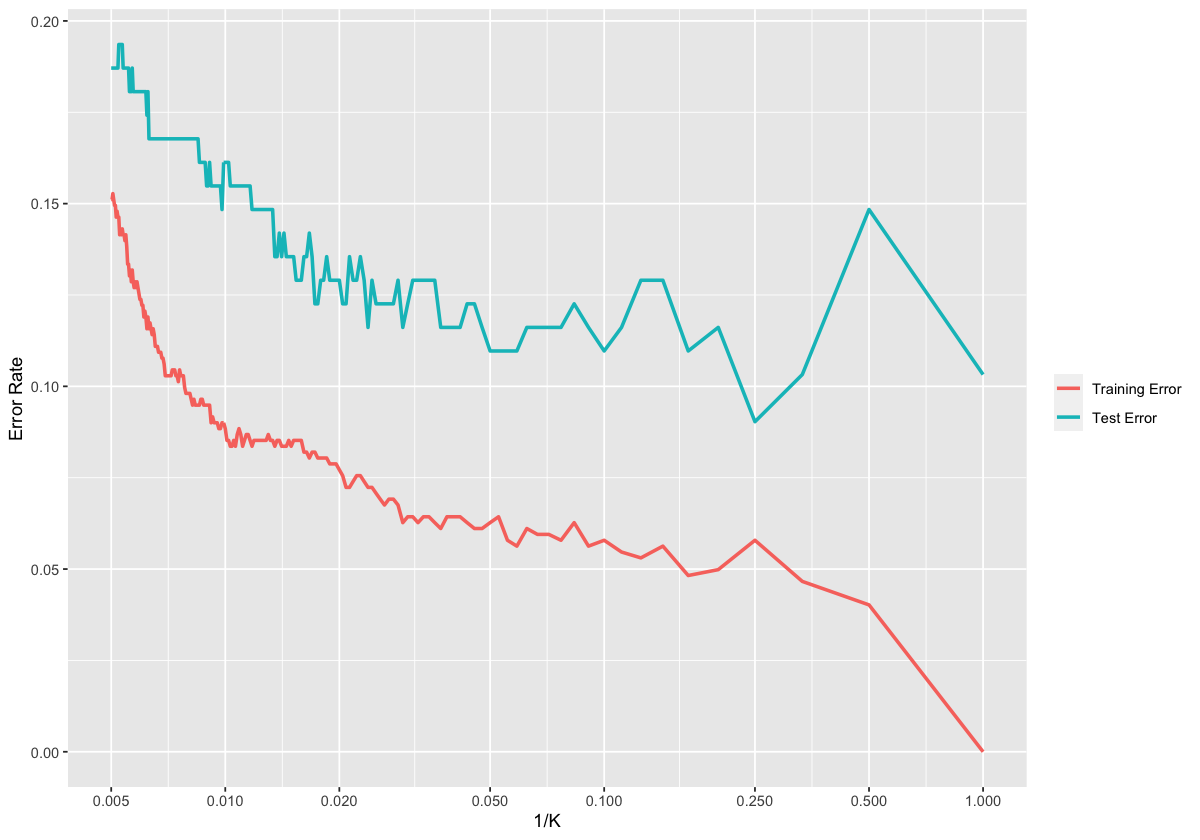

In [4]:
options(repr.plot.width=10, repr.plot.height=7)
errors %>% ggplot(mapping = aes(x = 1/k_range, y = value, color = variable)) + 
    geom_line(size = 1) +
    scale_x_continuous(trans = "log", breaks = c(0.005, 0.01, 0.02, 0.05, 0.10, 0.25, 0.50, 1)) + 
    scale_color_discrete(name = NULL, breaks = c("train_error", "test_error"), 
                         labels = c("Training Error", "Test Error")) + 
    ylab("Error Rate") + xlab("1/K")

We can see that as $K$, the number of the nearest neighbors used, decreases, (or as $1/K$ increases), the overall trend of the training error decreases (although fluctuating) but the trend of test error decreases at first and then at the value of $K = 4$, the trend of test error starts to increase. The training error reaches the minimum at the value of $K = 1$ and the test error reaches the minimum at the value of $K = 4$.

### 2. Cross Validation for Optimal K

In [5]:
loocv_error = 1 - Rfast::knn.cv(nfolds = nrow(train.X), y = train.label, x = train.X, k = 1:200)$crit
fold5_error = 1 - Rfast::knn.cv(nfolds = 5, y = train.label, x = train.X, k = 1:200)$crit
fold10_error = 1 - Rfast::knn.cv(nfolds = 10, y = train.label, x = train.X, k = 1:200)$crit

In [6]:
cv.test.errors = data.frame(k_range, loocv_error, fold5_error, fold10_error, test_error)
cv.test.errors = melt(cv.test.errors, id.vars = 'k_range')

In [7]:
# k suggested by LOOCV, 5-fold CV, 10-fold CV and test error
loocv_k = k_range[which.min(loocv_error)]
fold5_k = k_range[which.min(fold5_error)]
fold10_k = k_range[which.min(fold10_error)]
test_k = k_range[which.min(test_error)]
c(loocv_k, fold5_k, fold10_k, test_k)

[1] 30 10  5  4

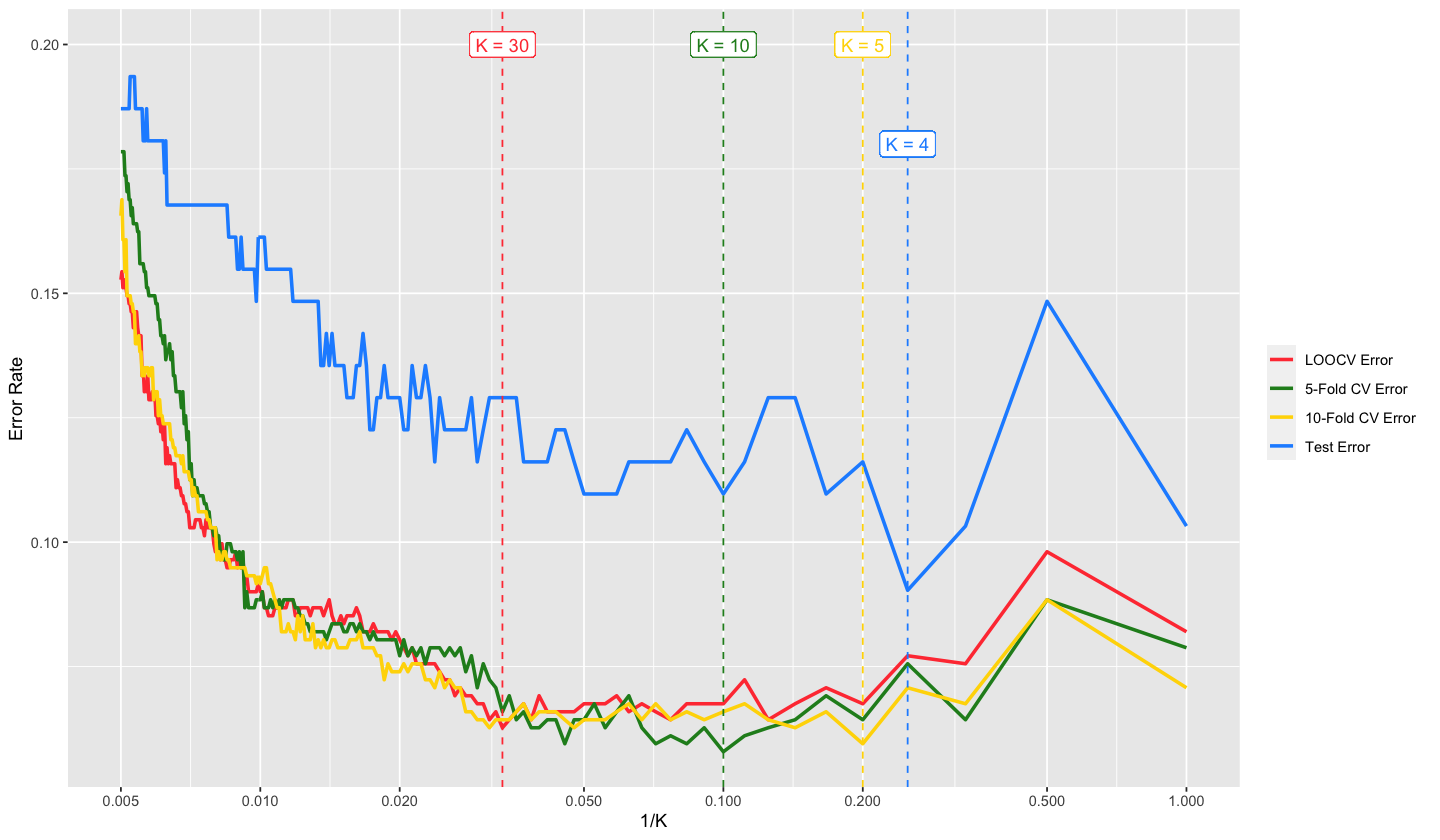

In [8]:
options(repr.plot.width=12, repr.plot.height=7)
cv.test.errors %>% ggplot(mapping = aes(x = 1/k_range, y = value, color = variable)) + 
    geom_line(size = 1)+ 
    scale_x_continuous(trans = "log", breaks = c(0.005, 0.01, 0.02, 0.05, 0.10, 0.20, 0.50, 1)) + 
    scale_color_manual(values = c("brown1", "forestgreen", "gold1", "dodgerblue"), name = NULL, 
                         breaks = c("loocv_error", "fold5_error", "fold10_error", "test_error"), 
                         labels = c("LOOCV Error", "5-Fold CV Error", "10-Fold CV Error", "Test Error")) + 
    ylab("Error Rate") + xlab("1/K") + 
    geom_vline(aes(xintercept = 1/loocv_k), color = "brown1", linetype = "dashed") + 
    geom_label(aes(x = 1/loocv_k, y = 0.2, label = "K = 30"), color = "brown1") + 
    geom_vline(aes(xintercept = 1/fold5_k), color = "forestgreen", linetype = "dashed") + 
    geom_label(aes(x = 1/fold5_k, y = 0.2, label = "K = 10"), color = "forestgreen") + 
    geom_vline(aes(xintercept = 1/fold10_k), color = "gold1", linetype = "dashed") + 
    geom_label(aes(x = 1/fold10_k, y = 0.2, label = "K = 5"), color = "gold1") + 
    geom_vline(aes(xintercept = 1/test_k), color = "dodgerblue", linetype = "dashed") + 
    geom_label(aes(x = 1/test_k, y = 0.18, label = "K = 4"), color = "dodgerblue")

The best $K$:

- According to LOOCV, $K = 30$;

- According to 5-fold CV, $K = 10$;

- According to 10-fold CV, $K = 5$;

- According to test error, $K = 4$.

Similarities:

- The errors for LOOCV, 5-fold CV, 10-fold CV and test data all decrease at first and then after reaching some minimum, the errors start to increase, as $1/K$ increases or $K$ decreases.

- The values of errors given by LOOCV, 5-fold CV and 10-fold CV at each $K$ value are pretty close.

Differences:

- The values of errors for test data are always larger than the values of errors for LOOCV, 5-fold CV and 10-fold CV.

- The $K$'s that give the minimum error (the best $K$) for LOOCV, 5-fold CV, 10-fold CV and test data are different. We can see that 
$$K_{LOOCV}>K_{5-fold}>K_{10-fold}>K_{test},$$
the best $K$ given by 10-fold CV is closer to the best $K$ given by test error. As the number of folds used for cross validation increases, the overfitting problem is more obvious.

### 3. Training Error and Test Error for different K

In [9]:
all_errors = data.frame(matrix(0, 7, 2))
colnames(all_errors) = c("Training Error", "Test Error")
rownames(all_errors) = c("LOOCV K = 30", "5-Fold K = 10", "10-Fold K = 5", "Test K = 4", "LDA", "QDA", "Logistic")

In [10]:
# LDA model
LDA.model = lda(Private~., data = train.data)

# training error
LDA.train.pred = predict(LDA.model, train.data)$class
all_errors['LDA', 'Training Error'] = mean(LDA.train.pred != train.data$Private)

# test error
LDA.test.pred = predict(LDA.model, test.data)$class
all_errors['LDA', 'Test Error'] = mean(LDA.test.pred != test.data$Private)

# QDA model
QDA.model = qda(Private~., data = train.data)

# training error
QDA.train.pred = predict(QDA.model, train.data)$class
all_errors['QDA', 'Training Error'] = mean(QDA.train.pred != train.data$Private)

# test error
QDA.test.pred = predict(QDA.model, test.data)$class
all_errors['QDA', 'Test Error'] = mean(QDA.test.pred != test.data$Private)

# Logistic
logit.model = glm(Private~., data = train.data, family = binomial(link = "logit"))

# training error
logit.train.pred = ifelse(predict(logit.model, train.data, type = "response") > 0.5, "Yes", "No")
all_errors['Logistic', 'Training Error'] = mean(logit.train.pred != train.data$Private)

# test error
logit.test.pred = ifelse(predict(logit.model, test.data, type = "response") > 0.5, "Yes", "No")
all_errors['Logistic', 'Test Error'] = mean(logit.test.pred != test.data$Private)

# KNN with LOOCV K = 30
all_errors['LOOCV K = 30', 'Training Error'] = train_error[which(k_range == 30)]
all_errors['LOOCV K = 30', 'Test Error'] = test_error[which(k_range == 30)]

# KNN with 5-fold CV K = 18
all_errors['5-Fold K = 10', 'Training Error'] = train_error[which(k_range == 10)]
all_errors['5-Fold K = 10', 'Test Error'] = test_error[which(k_range == 10)]

# KNN with 10-fold CV K = 12
all_errors['10-Fold K = 5', 'Training Error'] = train_error[which(k_range == 5)]
all_errors['10-Fold K = 5', 'Test Error'] = test_error[which(k_range == 5)]

# KNN with Test Error K = 4
all_errors['Test K = 4', 'Training Error'] = train_error[which(k_range == 4)]
all_errors['Test K = 4', 'Test Error'] = test_error[which(k_range == 4)]

In [11]:
all_errors

,Training Error,Test Error
,<dbl>,<dbl>
LOOCV K = 30,0.06430868,0.12903226
5-Fold K = 10,0.05787781,0.10967742
10-Fold K = 5,0.04983923,0.11612903
Test K = 4,0.05787781,0.09032258
LDA,0.05466238,0.09677419
QDA,0.07877814,0.14838710
Logistic,0.05627010,0.09677419


In [12]:
all_errors[, 'Model'] = rownames(all_errors)
rownames(all_errors) = NULL

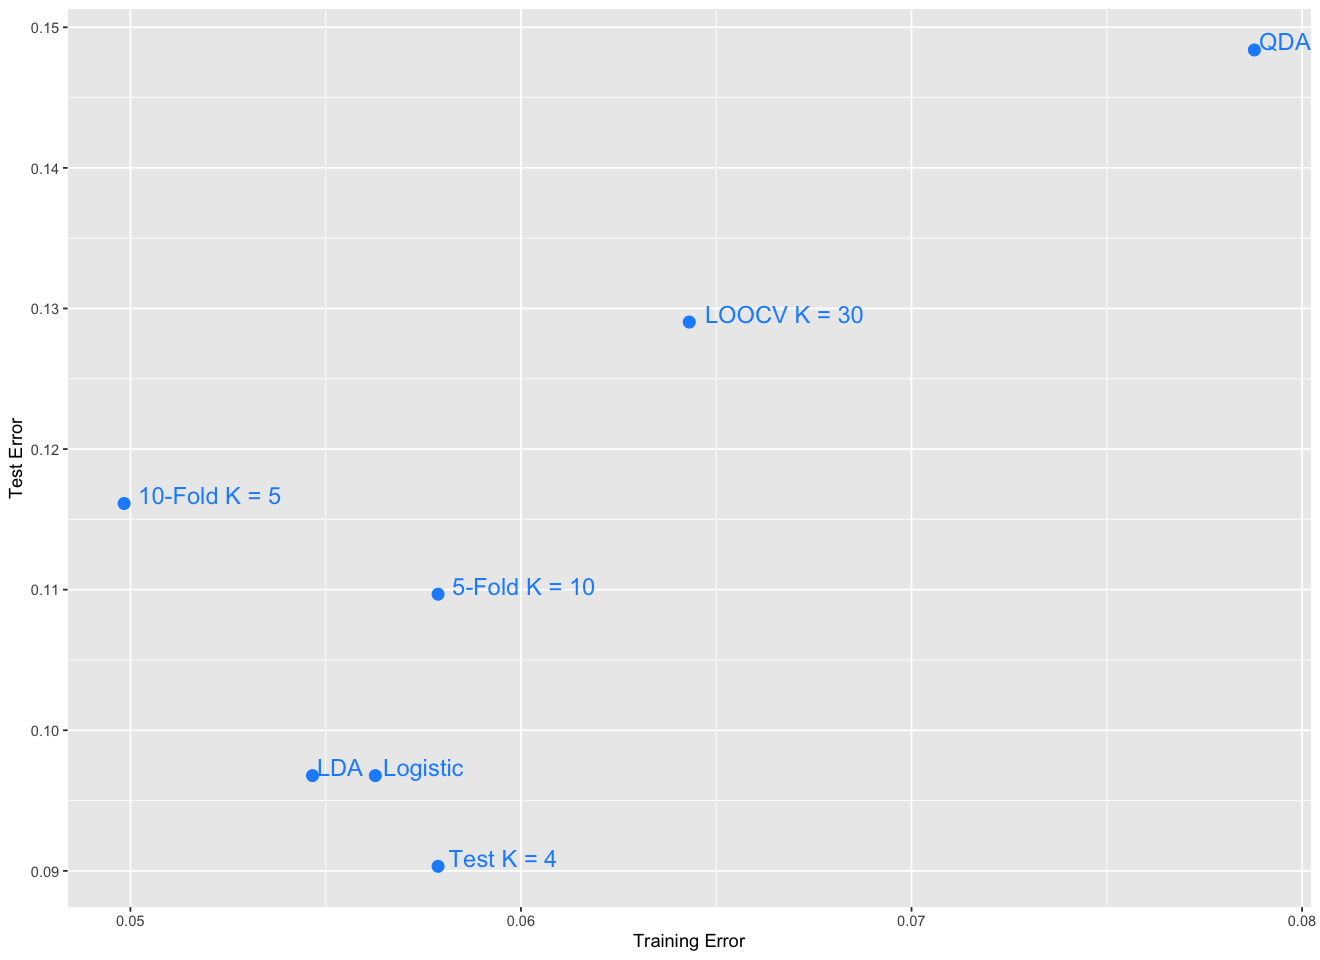

In [13]:
options(repr.plot.width=11, repr.plot.height=8)
ggplot(data = all_errors, 
       mapping = aes(x = `Training Error`, y = `Test Error`, label = Model)) + 
geom_point(size = 3, color = "dodgerblue") + 
geom_text(hjust=-0.1, vjust=0, size = 5, color = "dodgerblue")

Performance according to training errors (from best to worst): 

- KNN with $K = 5$ (10-fold CV), 

- LDA, 

- Logistic, 

- KNN with $K = 4$ (test error), KNN with $K = 10$ (5-fold CV), 

- KNN with $K = 30$ (LOOCV), 

- QDA.

Performance according to test errors (from best to worst): 

- KNN with $K = 4$ (test error), 

- LDA, Logistic, 

- KNN with $K = 10$ (5-fold CV), 

- KNN with $K = 5$ (10-fold CV), 

- KNN with $K = 30$ (LOOCV), 

- QDA.

According to the training error, KNN with $K = 5$, which is selected by 10-fold cross validation, performs best; according to the test error, KNN with $K = 4$ performs best. QDA gives the largest training error and test error.

It can be seen that KNN with smaller $K$'s perform relatively better, which might suggest that **the distribution of the classes** is separated well in the space of predictors, there are several points close to the boundary of two classes (larger $K$ perform worse than smaller $K$). And it might also suggest that **the boundary** is more likely to be linear than curved (LDA), because LDA performs better than QDA.